# AIAp Miniproject 2

## Project Data
- Teammembers: Leo Oetterli, Sylvester Homberger
- Version: 2024-04-30

## Contents

- Imports
- Configs
- Dataset
- Exploratory data analysis
- Architecture (common functions)
- Architecture 1 (underfitting)
- Architecture 2 (overfitting)
- Architecture 2 (optimized)
- Quantification of the model performance
- Final discussion

## Imports

In [6]:
import math
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics as sk_metrics
from sklearn import utils as sk_utils
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras import utils as keras_utils
from tensorflow.keras import models as keras_models
from tensorflow.keras import layers as keras_layers
from tensorflow.keras import regularizers as keras_regularizers

## Configs

In [7]:
SEED = 42

## Dataset

### b) Citation and description

For our project we used the following data:

- **Title:** Architectural Heritage Elements Dataset
- **Subtitle:** 128 (creative commons) revised
- **Version:** 1
- **Publication Date:** 2017-02-20
- **Author:** Jose Llamas
- **Organization:** Fundación CARTIF
- **Source:** https://correo.cartif.es/home/joslla@cartif.es/Briefcase/Architectural_Heritage_Elements_image_Dataset/Architectural_Heritage_Elements_Dataset_128%28creative_commons%29.zip
- **Media:** .jpg in .zip
- **Download:** 2024-03-26

The raw data was extracted with Windows. We then added it to our ["AIAp Miniproject 2"](https://gitlab.ost.ch/sylvester.homberger/aiap-miniproject-2) repository on the Gitlab instance of OST.

This dataset consists of 10437 RGB 64x64 jpg images classified in 11 categories:
- Altar: 828 images
- Apse: 505 images
- Bell tower: 1057 images
- Column: 1914 images
- Dome (inner): 589 images
- Dome (outer): 1175 images
- Flying buttress: 405 images
- Gargoyle (and Chimera): 1562 images
- Portal: 307 images
- Stained glass: 998 images
- Vault: 1097 images

As "flying buttress" and "portal" do not satisfy the minimal samples requirement of 500, we manually moved them out of our dataset into a separate folder. Our adjusted dataset therefore fulfils the requirements:
- RGB images of 9 classes
- Each has more than 500 samples and the total is 9725 images
- They have a resolution of 64x64 pixels

### c) Load and split data

In [8]:
data_folder = Path(os.getcwd()).parent / "data"
raw_folder = data_folder / "raw" / "Architectural_Heritage_Elements_Dataset_64(creative_commons)_revised"

raw_train_val_data = keras_utils.image_dataset_from_directory(
  raw_folder,
  image_size=(64, 64),
  seed=SEED,
  validation_split=0.3,
  subset="training"
)

raw_test_data = keras_utils.image_dataset_from_directory(
  raw_folder,
  image_size=(64, 64),
  seed=SEED,
  validation_split=0.3,
  subset="validation"
)

raw_training_data, raw_validation_data = keras_utils.split_dataset(raw_train_val_data, left_size=0.8, shuffle=True)

raw_test_data = raw_test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

classes = raw_train_val_data.class_names

Found 9725 files belonging to 9 classes.
Using 6808 files for training.
Found 9725 files belonging to 9 classes.
Using 2917 files for validation.


## Exploratory data analysis

### Plot a few images

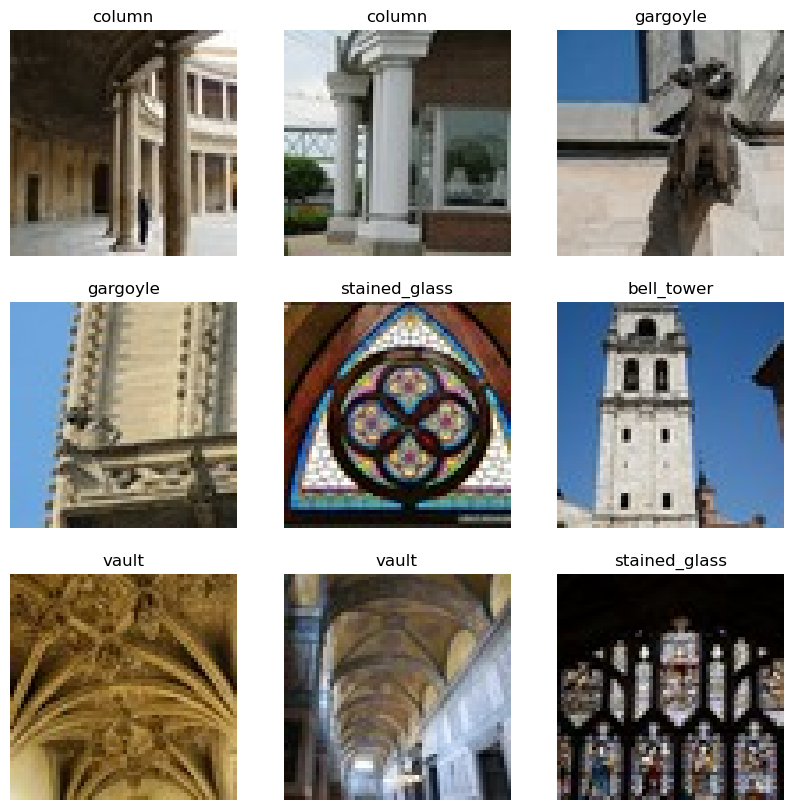

In [9]:
def show_pictures(data=raw_train_val_data):
    plt.figure(figsize=(10, 10))
    for images, labels in data.take(1):
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(classes[labels[i]])
            plt.axis("off")
show_pictures()

### Samples per class

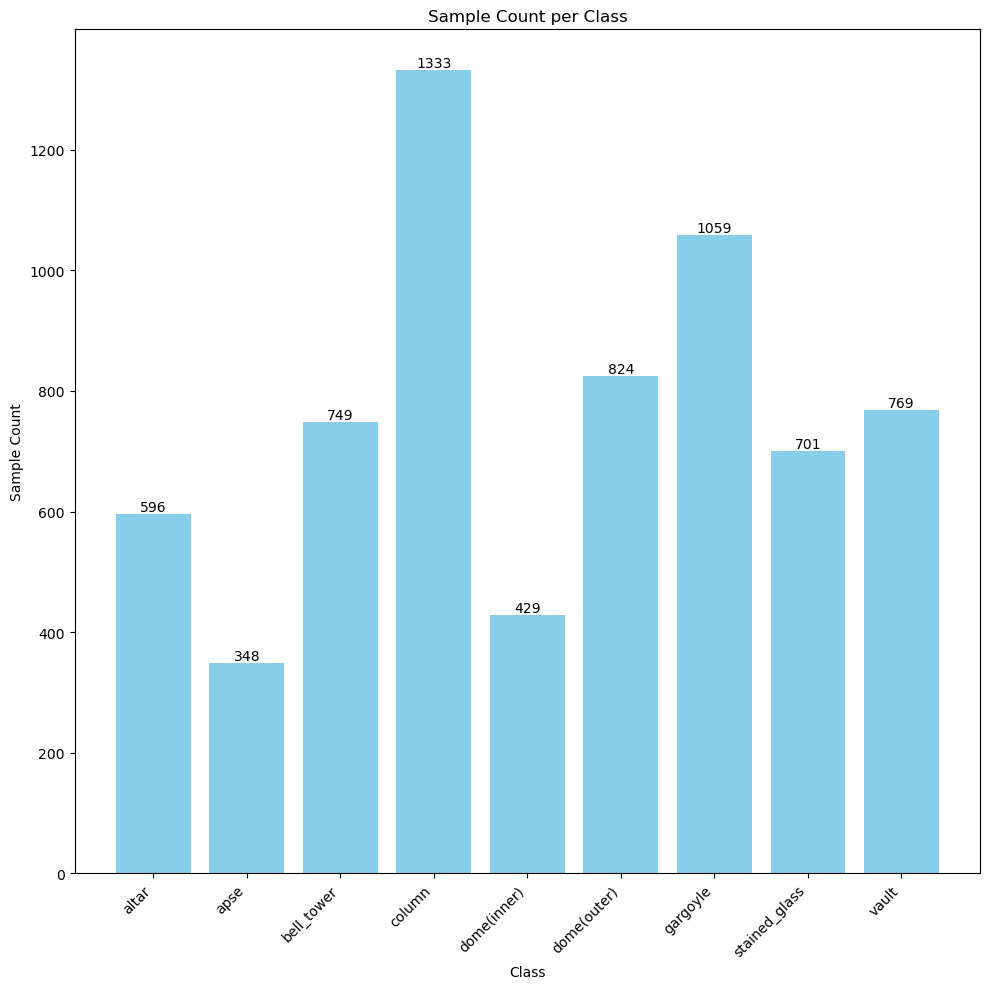

In [10]:
# Count samples per class
class_counts = raw_train_val_data.reduce(
    initial_state=tf.zeros(len(classes), dtype=tf.int32),
    reduce_func=lambda count, images_labels: count + tf.math.bincount(images_labels[1], minlength=len(classes)))

# Extract numbers
class_counts_values = [count.numpy() for count in class_counts]

# Plot samples per class
plt.figure(figsize=(10, 10))
bars = plt.bar(classes, class_counts_values, color='skyblue')
plt.bar_label(bars, labels=class_counts_values, label_type='edge', color='black')
plt.xlabel('Class')
plt.ylabel('Sample Count')
plt.title('Sample Count per Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


The dataset is not balanced. Classes need to be weighted for training.

### Distribution of values

Red range: 	 	 0.0  -  255.0
Green range: 	 0.0  -  255.0
Blue range: 	 0.0  -  255.0


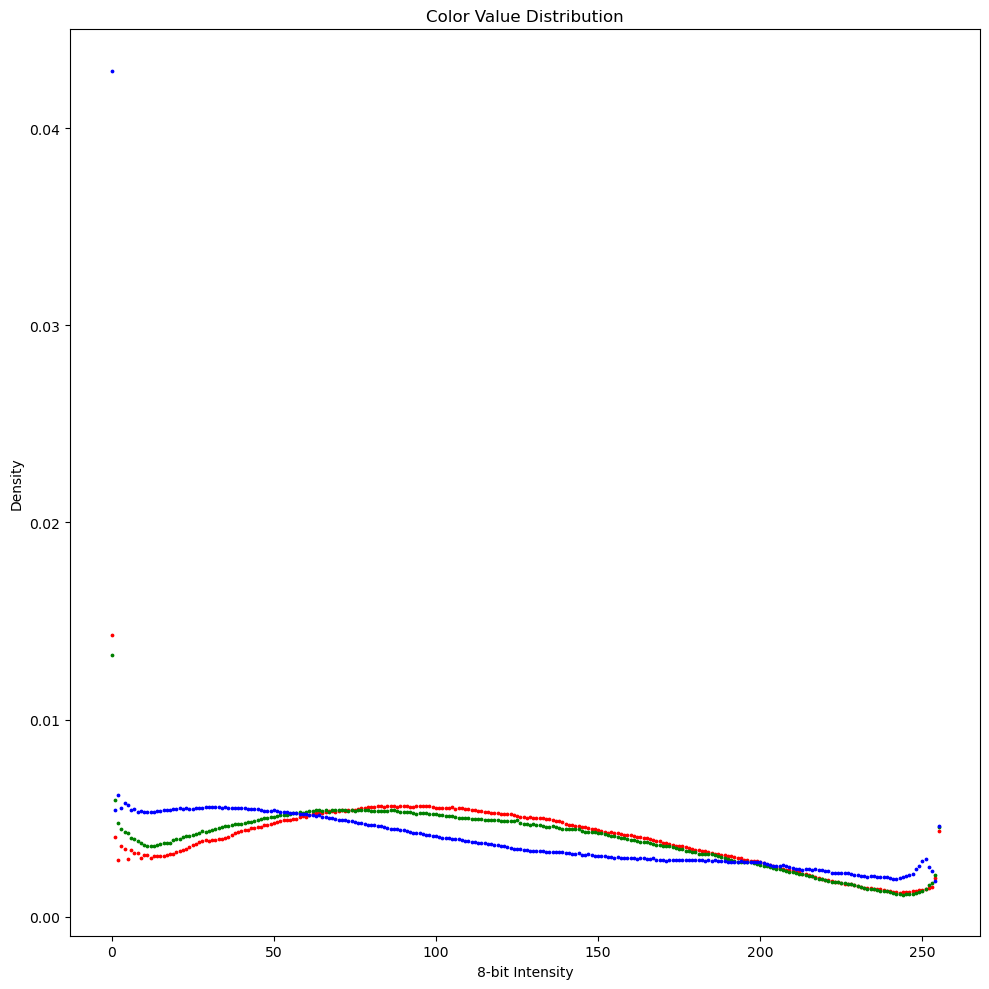

In [11]:
# Concatenate all images in the dataset
images_np = np.concatenate([images.numpy() for images, _ in raw_training_data])

# Reshape to (num_images * height * width, channels)
images_np = images_np.reshape(-1, images_np.shape[3])

# Extract RGB values
red_values = images_np[:, 0]
green_values = images_np[:, 1]
blue_values = images_np[:, 2]

# Get range of values
red_max = np.max(red_values)
red_min = np.min(red_values)
print("Red range: \t \t", red_min, " - ", red_max)
green_max = np.max(green_values)
green_min = np.min(green_values)
print("Green range: \t", green_min, " - ", green_max)
blue_max = np.max(blue_values)
blue_min = np.min(blue_values)
print("Blue range: \t", blue_min, " - ", blue_max)

# Calculate the distribution
red_distribution = np.histogram(red_values, bins=256, density=True)[0]
green_distribution = np.histogram(green_values, bins=256, density=True)[0]
blue_distribution = np.histogram(blue_values, bins=256, density=True)[0]

# Plot all color densities on the same plot
plt.figure(figsize=(10, 10))
plt.scatter(range(len(red_distribution)), red_distribution, color='red', s=3)
plt.scatter(range(len(green_distribution)), green_distribution, color='green', s=3)
plt.scatter(range(len(blue_distribution)), blue_distribution, color='blue', s=3)
plt.xlabel('8-bit Intensity')
plt.ylabel('Density')
plt.title('Color Value Distribution')
plt.tight_layout()

We observe significant peaks at the extreme ends of the value range (0 and 255). The underlying cause is unclear to us, as we did not generate the images ourselves. 

We observed a clear distinction in the distribution of blue intensity compared to that of red and green. While all colors demonstrate a decrease in density as intensity increases, there are notable variations among them. Specifically, red and green intensities seem to follow a somewhat normal distribution pattern, whereas blue intensity exhibits a nearly monotonic decline.

This decrease in density across intensities could potentially stem from heightened sensitivity of the camera equipment at higher levels, leading to a stretched scale. However, when examining the discrepancy between blue and the other colors, our initial online investigation did not provide immediate insights into the underlying cause of this disparity.

However, those phenomena should not hinder meaningful model training, provided it does not systematically convey information regarding the classes.

Additionally, we need to rescale the value range from [0 - 255] to [0 - 1]. The below function will also be used for the test data later.

### Required adjustments from result of analysis

#### Scale images

In [12]:
def scale_image_dataset(dataset):
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    return dataset.map(lambda x, y: (normalization_layer(x), y))

training_data = scale_image_dataset(raw_training_data)
validation_data = scale_image_dataset(raw_validation_data)

#### labels in numpy arrays

In [13]:
def get_labels(data):
    true_labels = []
    for f, l in data:
        true_labels.extend(l.numpy())
    return np.array(true_labels)

def get_predicted_labels(model, data):
    predictions = model.predict(data)
    scores = []
    for prediction in predictions:
        scores.append(tf.nn.softmax(prediction))
    return np.array(np.argmax(scores, axis=1))

#### Calculate class weights

In [14]:
def generate_class_weights(data=training_data):
    # create list of all labels
    labels = get_labels(data)
    # Calculate class weights
    class_weights = sk_utils.class_weight.compute_class_weight(
        class_weight='balanced', 
        classes=np.unique(labels),
        y=labels
    )
    # Convert class weights to a dictionary format
    return dict(zip(np.unique(labels), class_weights))

## Architecture (common functions)

#### Compile and train function

In [15]:
def compile_and_train(model, epochs=50, t_data=training_data, v_data=validation_data):
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model.fit(t_data, validation_data=v_data, epochs=epochs, class_weight=generate_class_weights())

#### visualize accuracy and loss function

In [16]:
def visualize_model(history, plot_title):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(accuracy))
    
    plt.figure(figsize=(20, 7))
    plt.suptitle(plot_title, fontsize='x-large')
    
    plt.subplot(1, 2, 1)
    training_accuracy_label = f'Training Accuracy -> {(accuracy[-1]):.3f}'
    plt.plot(epochs_range, accuracy, label=training_accuracy_label)
    validation_accuracy_label = f'Validation Accuracy -> {(val_accuracy[-1]):.3f}'
    plt.plot(epochs_range, val_accuracy, label=validation_accuracy_label)
    plt.ylim(0, 1)
    plt.xlim(0, 50)
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    training_loss_label = f'Training Loss -> {(loss[-1]):.3f}'
    plt.plot(epochs_range, loss, label=training_loss_label)
    validation_loss_label = f'Validation Loss -> {(val_loss[-1]):.3f}'
    plt.plot(epochs_range, val_loss, label=validation_loss_label)
    plt.ylim(0, 3)
    plt.xlim(0, 50)
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid(True)

    plt.show()

#### visualize the confusion matrix

In [17]:
def calculate_confusion_matrix(model, v_data=validation_data, normalize=None):
    true_labels = get_labels(v_data)
    predicted_labels = get_predicted_labels(model, v_data)
    return sk_metrics.confusion_matrix(true_labels, predicted_labels, normalize=normalize)

def visualize_confusion_matrix(confusion_matrix, color_map='Blues', normalize=None):
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.get_cmap(color_map))
    plt.title('Confusion Matrix - normalize: ' + str(normalize))
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Display the counts in each cell
    thresh = confusion_matrix.max() / 2.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, format(confusion_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if confusion_matrix[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, data, normalize=None, color_map='Blues'):
    conf_matrix = calculate_confusion_matrix(model, data, normalize)
    visualize_confusion_matrix(conf_matrix, color_map, normalize)

## Architecture 1 (underfitting)

#### Model

In [18]:
def get_underfitted_model():
    model = keras_models.Sequential()
    model.add(keras_layers.Conv2D(
        filters=3, kernel_size=5, strides=4, padding='same', activation='relu', input_shape=(64, 64, 3)
    ))
    model.add(keras_layers.MaxPooling2D((4,4)))
    model.add(keras_layers.Flatten())
    model.add(keras_layers.Dense(len(classes)))
    return model
underfitting_model = get_underfitted_model()

#### Summary

In [19]:
underfitting_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 3)         228       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 3)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 9)                 441       
                                                                 
Total params: 669
Trainable params: 669
Non-trainable params: 0
_________________________________________________________________


### Compile and train the model

In [20]:
underfitting_history = compile_and_train(model=underfitting_model)

Epoch 1/50
171/171 [==============================] - 1s 4ms/step - loss: 2.2263 - accuracy: 0.1348 - val_loss: 2.1454 - val_accuracy: 0.1791
Epoch 2/50
171/171 [==============================] - 1s 3ms/step - loss: 2.0731 - accuracy: 0.2314 - val_loss: 1.9873 - val_accuracy: 0.2452
Epoch 3/50
171/171 [==============================] - 1s 3ms/step - loss: 1.8435 - accuracy: 0.3022 - val_loss: 1.7614 - val_accuracy: 0.3385
Epoch 4/50
171/171 [==============================] - 0s 3ms/step - loss: 1.6817 - accuracy: 0.3649 - val_loss: 1.6650 - val_accuracy: 0.3825
Epoch 5/50
171/171 [==============================] - 0s 3ms/step - loss: 1.5935 - accuracy: 0.3935 - val_loss: 1.6008 - val_accuracy: 0.4141
Epoch 6/50
171/171 [==============================] - 1s 3ms/step - loss: 1.5335 - accuracy: 0.4161 - val_loss: 1.5552 - val_accuracy: 0.4339
Epoch 7/50
171/171 [==============================] - 1s 3ms/step - loss: 1.4881 - accuracy: 0.4361 - val_loss: 1.5188 - val_accuracy: 0.4493
Epoch 

### Visualize training results

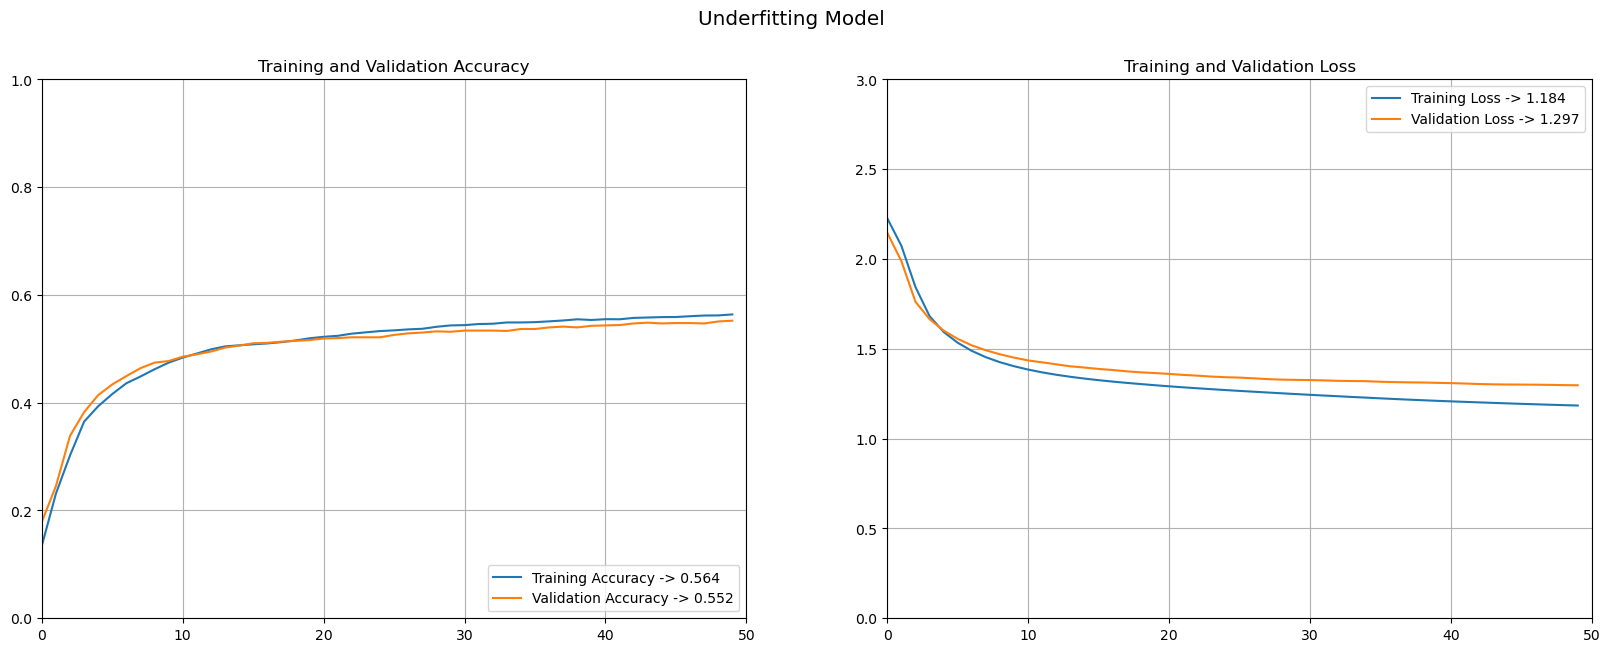

In [21]:
visualize_model(underfitting_history, 'Underfitting Model')

### Confusion Matrix

43/43 [==============================] - 0s 1ms/step


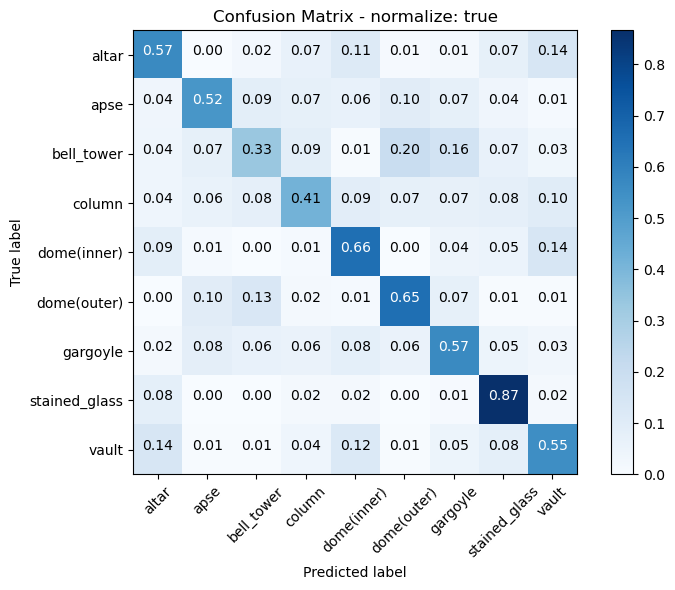

In [71]:
plot_confusion_matrix(underfitting_model, validation_data, 'true', 'Blues')

43/43 [==============================] - 0s 1ms/step


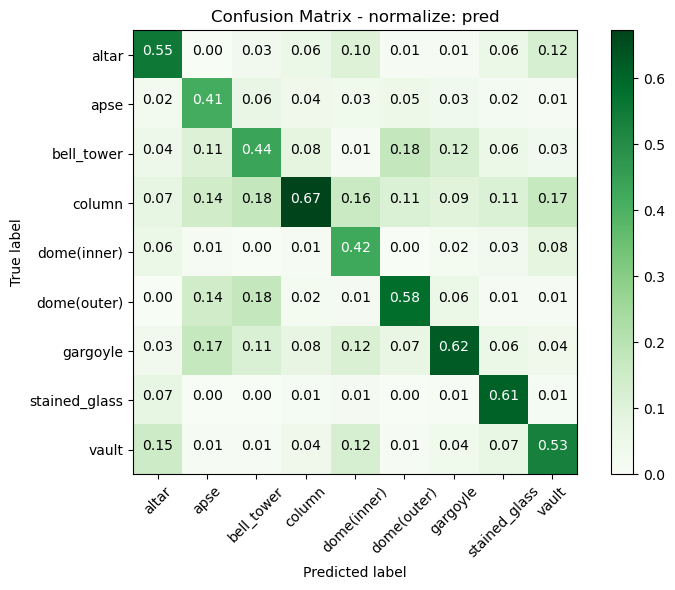

In [72]:
plot_confusion_matrix(underfitting_model, validation_data, 'pred', 'Greens')

43/43 [==============================] - 0s 1ms/step


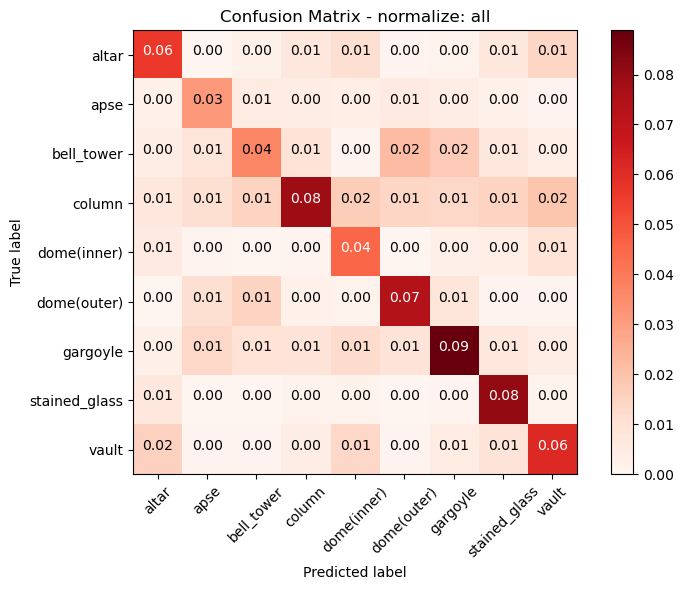

In [73]:
plot_confusion_matrix(underfitting_model, validation_data, 'all', 'Reds')

### Discussion

As required by the assignment, there are 2 trainable layers and the 669 trainable parameters which are below the maximum of about 2000. We added stride to one layer and used one MaxPooling to decrease the number of parameters. The stride of 4 is below the kernel size of 5. This is important, because if it was higher, whole columns / rows of the input to such a layer would be lost to the network. The stride would move further than the kernel size can cover.

We trained the model for 50 epochs and see the training loss converge at around 1.184. The training accuracy is around 0.564. The validation accuracy is around 0.552 and its loss around 1.297.

The training history for accuracy and loss evolves typically for underfitting models. That is, they stay close together for training and validation data. The validation loss does not increase with more training. Additionally the validation loss stays above the more complex optimized model (0.901). We therefore conclude that we observe underfitting. Also the accuracy stays below both more complex models of architecture 2 (0.784 and 0.818). Still, it is a lot better than guessing at random (1/9 = 0.111)

The model was very good at identifying stained glass with high recall(0.87) and good precision (0.61). The precision of column (0.67) and gargoyle (0.62) were a bit higher. The lowest recall was with bell tower (0.33), and column (0.41). The lowest precision was with apse (0.41), bell tower (0.44), and dome(inner) (0.42).

Interestingly precision was the highest for column even though recall was the second worst. False positives and negatives were high for all kinds of combinations, but without any noteworthy patterns.

## Architecture 2 (overfitting)

### Model

In [23]:
def get_overfitted_model():    
    model = keras_models.Sequential()
    model.add(keras_layers.Conv2D(
        filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(64, 64, 3)
    ))
    model.add(keras_layers.MaxPooling2D())
    model.add(keras_layers.Conv2D(
        filters=32, kernel_size=5, padding='same', activation='relu'
    ))
    model.add(keras_layers.MaxPooling2D())
    model.add(keras_layers.Conv2D(
        filters=64, kernel_size=7, padding='same', activation='relu'
    ))
    model.add(keras_layers.MaxPooling2D())
    model.add(keras_layers.Flatten())
    model.add(keras_layers.Dense(81, activation='relu'))
    model.add(keras_layers.Dense(len(classes)))
    return model
overfitting_model = get_overfitted_model()

### Summary

In [24]:
overfitting_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        12832     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        100416    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 64)        

### Compile and train the model

In [25]:
overfitting_history = compile_and_train(overfitting_model)

Epoch 1/50
171/171 [==============================] - 8s 48ms/step - loss: 1.5804 - accuracy: 0.3896 - val_loss: 1.4026 - val_accuracy: 0.4765
Epoch 2/50
171/171 [==============================] - 8s 48ms/step - loss: 1.1236 - accuracy: 0.5826 - val_loss: 1.0721 - val_accuracy: 0.6314
Epoch 3/50
171/171 [==============================] - 8s 49ms/step - loss: 0.8787 - accuracy: 0.6737 - val_loss: 0.9788 - val_accuracy: 0.6902
Epoch 4/50
171/171 [==============================] - 8s 49ms/step - loss: 0.7224 - accuracy: 0.7352 - val_loss: 0.9901 - val_accuracy: 0.6902
Epoch 5/50
171/171 [==============================] - 8s 48ms/step - loss: 0.5786 - accuracy: 0.7835 - val_loss: 0.9202 - val_accuracy: 0.7048
Epoch 6/50
171/171 [==============================] - 8s 49ms/step - loss: 0.4551 - accuracy: 0.8338 - val_loss: 0.8773 - val_accuracy: 0.7305
Epoch 7/50
171/171 [==============================] - 8s 48ms/step - loss: 0.3912 - accuracy: 0.8485 - val_loss: 0.7829 - val_accuracy: 0.7621

### Visualize training results

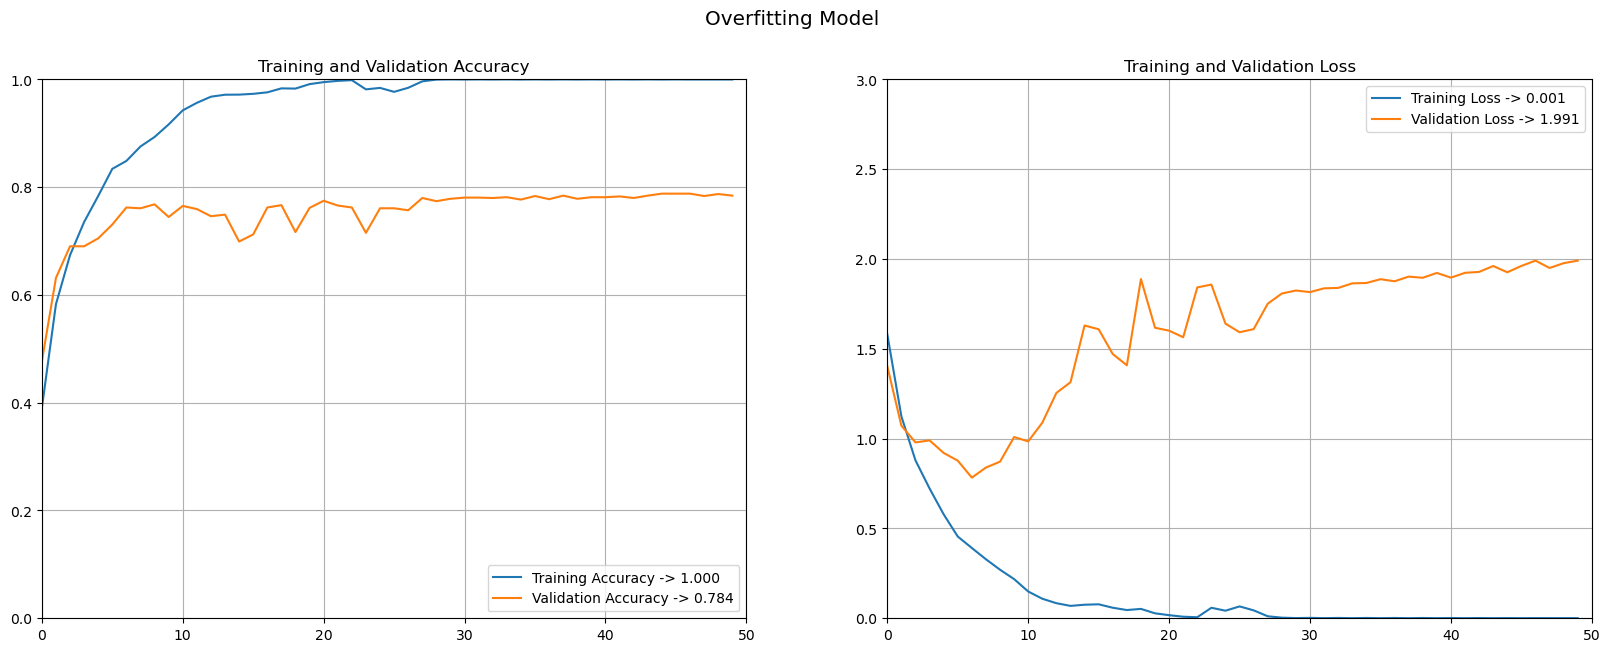

In [26]:
visualize_model(overfitting_history, 'Overfitting Model')

### Confusion Matrix

43/43 [==============================] - 1s 18ms/step


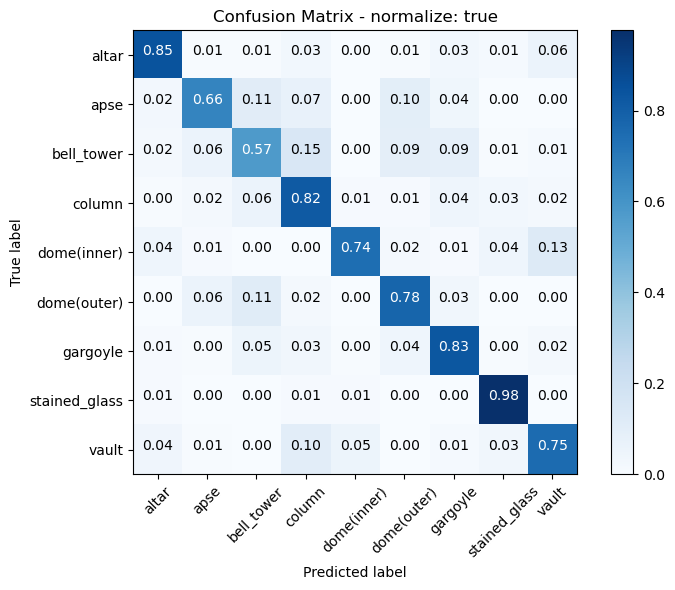

In [69]:
plot_confusion_matrix(overfitting_model, validation_data, 'true', 'Blues')

43/43 [==============================] - 1s 16ms/step


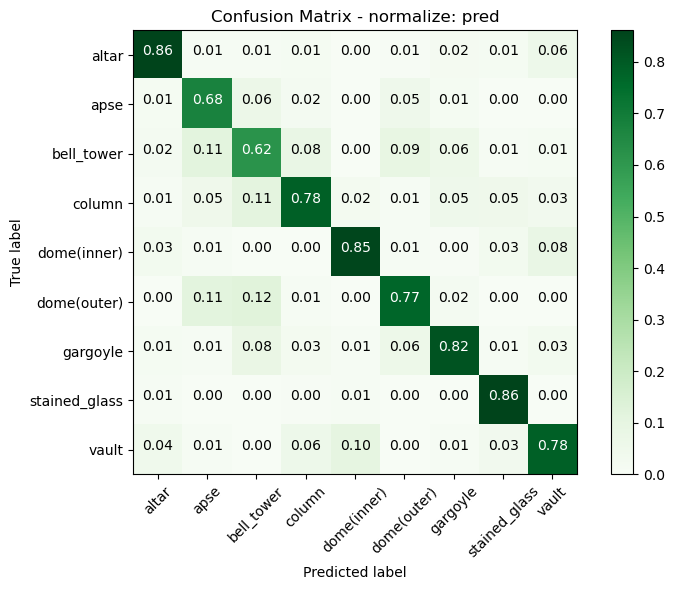

In [68]:
plot_confusion_matrix(overfitting_model, validation_data, 'pred', 'Greens')

43/43 [==============================] - 1s 17ms/step


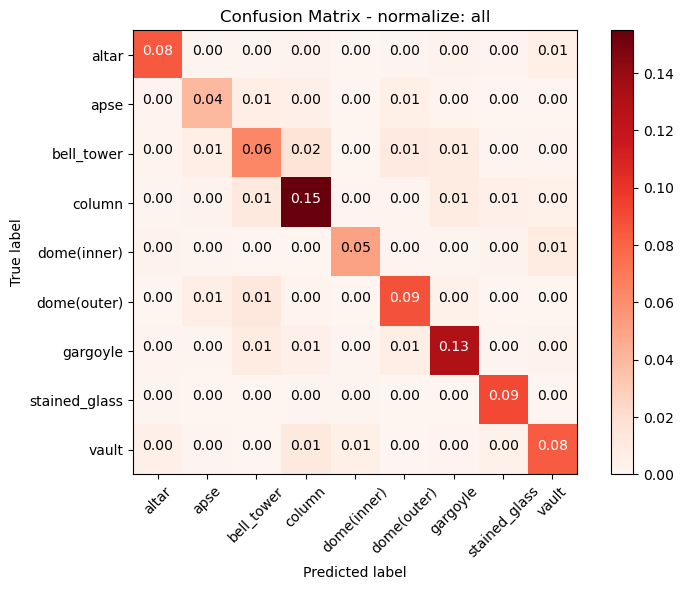

In [70]:
plot_confusion_matrix(overfitting_model, validation_data, 'all', 'Reds')

### Discussion

For architecture 2, we increased the numbers of trainable layers by adding two Conv2D and one Dense layer. The number of filters in the Conv2D layers was also increased massively and reaches 64 filters for the last one. The resulting model has 446'291 trainable parameters.

We trained the model for 50 epochs and see the training loss converge at around 0.001. The training accuracy is around 1.000. The validation accuracy is around 0.784 and its loss was at 1.991, but kept rising. It was interesting to see the strong reduction of variance in validation metrics after training metrics reached the boundaries of their possible values. We assume the miniscule training loss resulted in miniscule training gradients.

The training history for accuracy and loss evolves typically for overfitting models. That is, they don't stay together for training and validation data. The validation loss increases with more training. We therefore conclude that we observe overfitting. Also the accuracy is above the less complex model from architecture 1 (0.552).

The model was still best at identifying stained glass with high recall (0.98) and precision (0.86). The precision of altar was the same (0.86), and dome(inner) was just behind (0.85). The lowest recall and precision was with apse (0.66 and 0.68), and bell tower (0.57 and 0.62).

False positives and negatives were higher for some kinds of combinations than others. But they were generally low and, without any noteworthy patterns.

## Architecture 2 (optimized)

### Regularization Terms

In [28]:
# Low regularization
low_dropout_rate = 0.1
low_l2_lambda = 10**-6
# Optimized regularization
optimized_dropout_rate = 0.5
optimized_l2_lambda = 10**-3
# High regularization
high_dropout_rate = 0.65
high_l2_lambda = 10**-2

### Model

In [30]:
def get_optimized_model(dropout_rate, l2_lambda):
    model = keras_models.Sequential()
    model.add(keras_layers.Conv2D(
        filters=16, kernel_size=3, padding='same', activation='relu',
        kernel_regularizer=keras_regularizers.l2(l2_lambda), input_shape=(64, 64, 3)
    ))
    model.add(keras_layers.MaxPooling2D())
    model.add(keras_layers.Dropout(rate=dropout_rate))
    model.add(keras_layers.Conv2D(
        filters=32, kernel_size=5, padding='same', activation='relu',
        kernel_regularizer=keras_regularizers.l2(l2_lambda)
    ))
    model.add(keras_layers.MaxPooling2D())
    model.add(keras_layers.Dropout(rate=dropout_rate))
    model.add(keras_layers.Conv2D(
        filters=64, kernel_size=7, padding='same', activation='relu',
        kernel_regularizer=keras_regularizers.l2(l2_lambda)
    ))
    model.add(keras_layers.MaxPooling2D())
    model.add(keras_layers.Dropout(rate=dropout_rate))
    model.add(keras_layers.Flatten())
    model.add(keras_layers.Dense(
        81, activation='relu',
        kernel_regularizer=keras_regularizers.l2(l2_lambda)
    ))
    model.add(keras_layers.Dropout(rate=dropout_rate))
    model.add(keras_layers.Dense(
        len(classes),
        kernel_regularizer=keras_regularizers.l2(l2_lambda)
    ))
    return model

optimized_low_model = get_optimized_model(low_dropout_rate, low_l2_lambda)
optimized_model = get_optimized_model(optimized_dropout_rate, optimized_l2_lambda)
optimized_high_model = get_optimized_model(high_dropout_rate, high_l2_lambda)

### Summary

In [32]:
optimized_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 32, 32, 16)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 32)        12832     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 16, 16, 32)       

### Compile and train the model

In [33]:
optimized_low_history = compile_and_train(optimized_low_model)
optimized_history = compile_and_train(optimized_model)
optimized_high_history = compile_and_train(optimized_high_model)

Epoch 1/50
171/171 [==============================] - 9s 53ms/step - loss: 1.6665 - accuracy: 0.3388 - val_loss: 1.6366 - val_accuracy: 0.4104
Epoch 2/50
171/171 [==============================] - 9s 50ms/step - loss: 1.3094 - accuracy: 0.4905 - val_loss: 1.3061 - val_accuracy: 0.5830
Epoch 3/50
171/171 [==============================] - 9s 53ms/step - loss: 1.0850 - accuracy: 0.5988 - val_loss: 1.0710 - val_accuracy: 0.6417
Epoch 4/50
171/171 [==============================] - 8s 50ms/step - loss: 0.9013 - accuracy: 0.6675 - val_loss: 0.9353 - val_accuracy: 0.6887
Epoch 5/50
171/171 [==============================] - 9s 50ms/step - loss: 0.7725 - accuracy: 0.7121 - val_loss: 0.8523 - val_accuracy: 0.7173
Epoch 6/50
171/171 [==============================] - 9s 50ms/step - loss: 0.6846 - accuracy: 0.7481 - val_loss: 0.8662 - val_accuracy: 0.7085
Epoch 7/50
171/171 [==============================] - 9s 50ms/step - loss: 0.5808 - accuracy: 0.7861 - val_loss: 0.8206 - val_accuracy: 0.7342

### Visualize training results

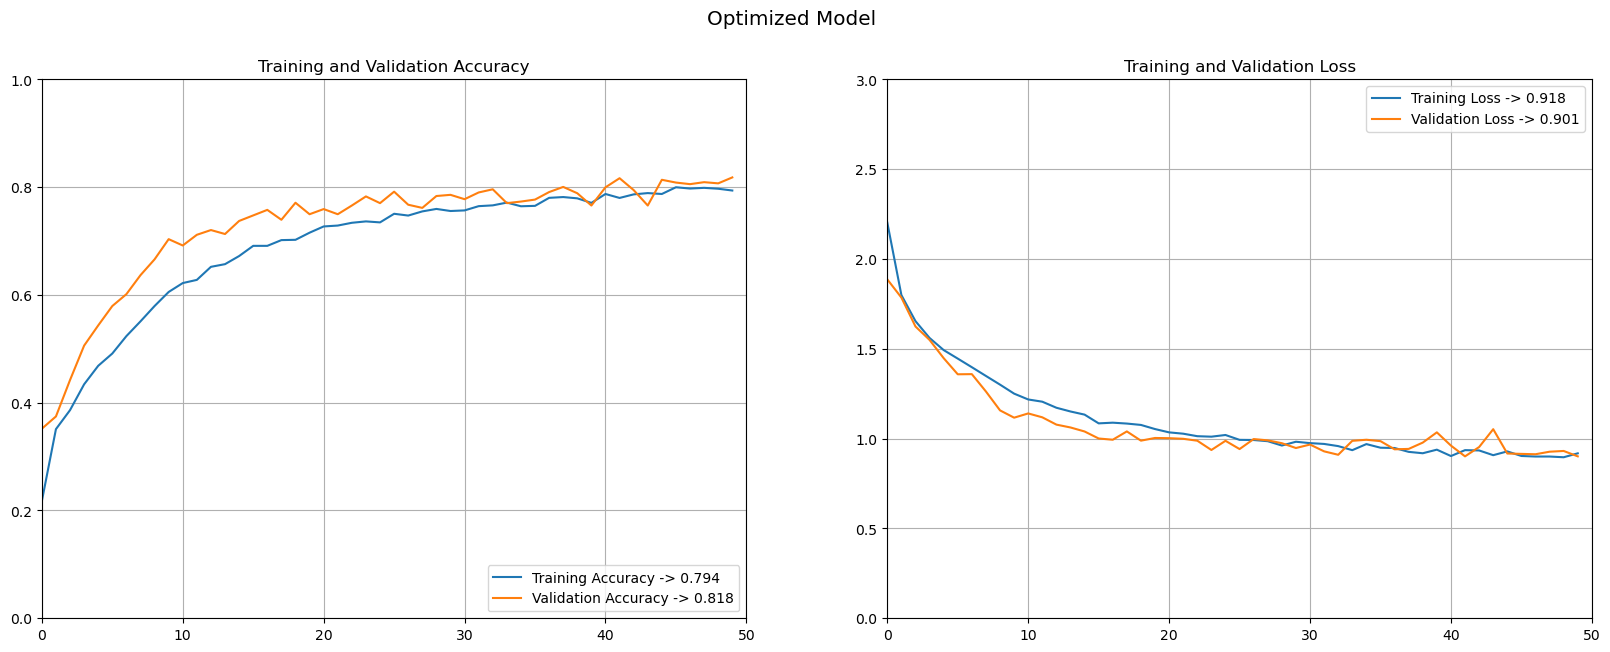

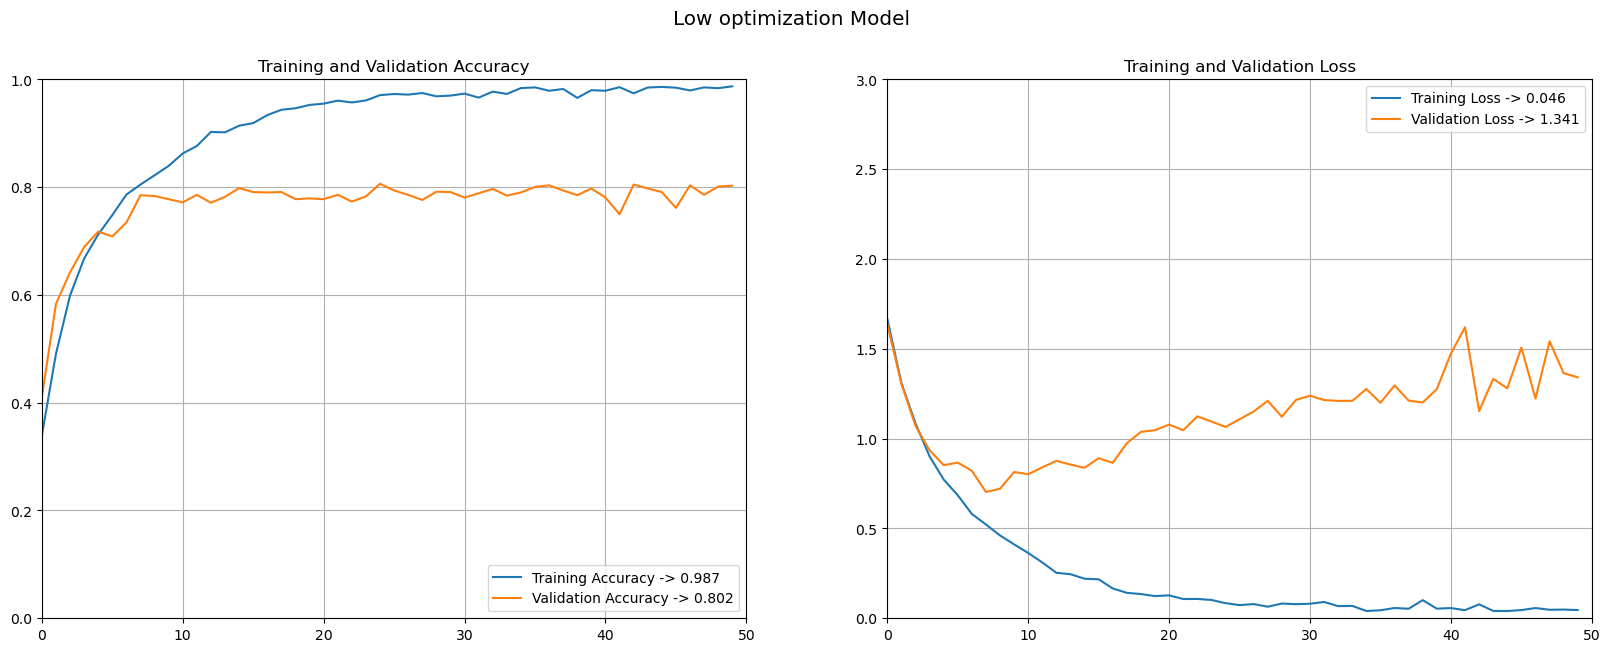

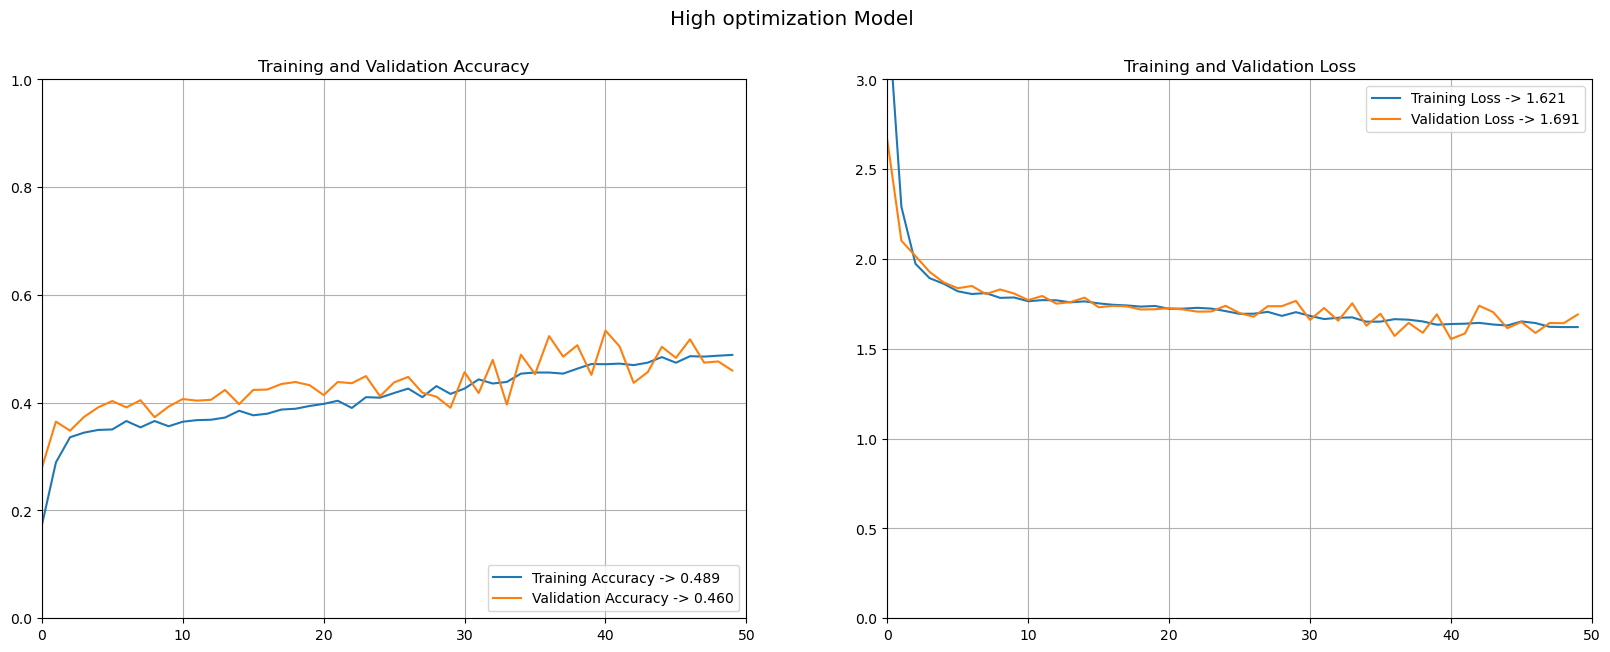

In [34]:
visualize_model(optimized_history, 'Optimized Model')
visualize_model(optimized_low_history, 'Low optimization Model')
visualize_model(optimized_high_history, 'High optimization Model')

### Confusion Matrix

43/43 [==============================] - 1s 18ms/step


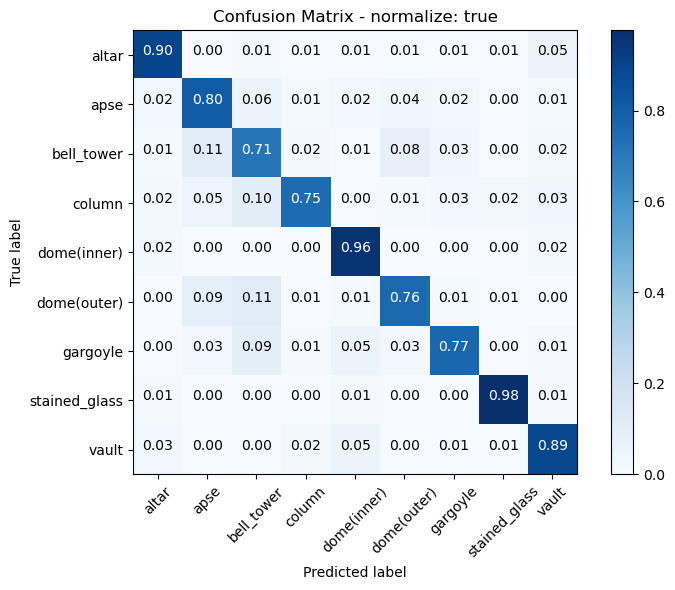

In [67]:
plot_confusion_matrix(optimized_model, validation_data, 'true', 'Blues')

43/43 [==============================] - 1s 16ms/step


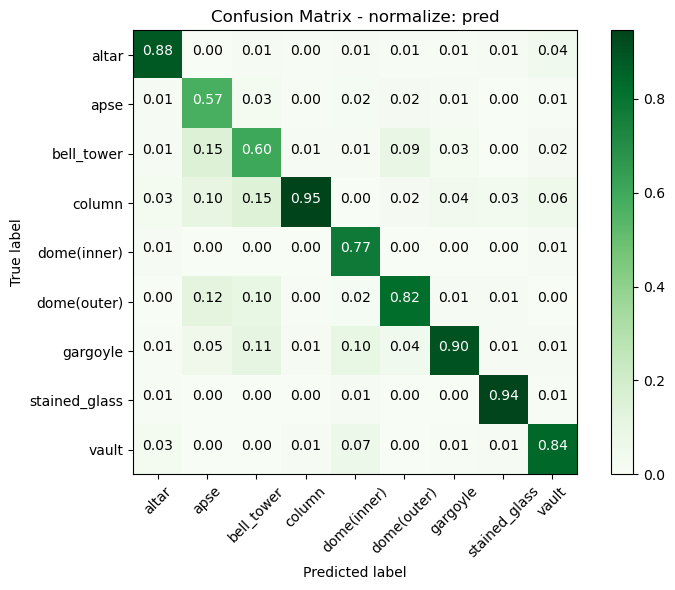

In [66]:
plot_confusion_matrix(optimized_model, validation_data, 'pred', 'Greens')

43/43 [==============================] - 1s 17ms/step


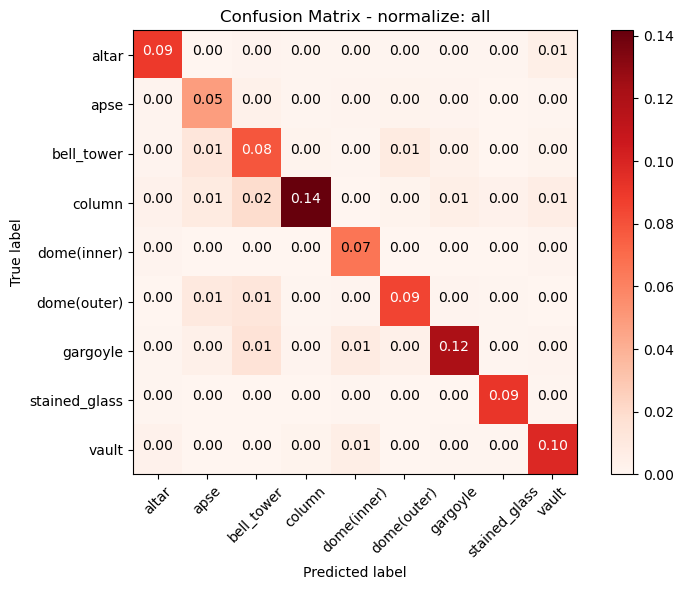

In [65]:
plot_confusion_matrix(optimized_model, validation_data, 'all', 'Reds')

### Discussion

To optimize architecture 2, we added a Dropout layers before every trainable layer and added L2 kernel_regularizer to all trainable layers. We defined one scalar hyperparameter for dropout_rate and l2_lambda each. Anything else we left unchanged.

Testing manually, we found that a dropout rate at 0.5 and a lambda at 10^-3 was less underfitting or overfitting than lower (0.1 and 10^-6 )and higher (0.65 and 10^-2) hyperparameters. This lies at the upper boundary of suggested values in the assignment. To get the model to actually start underfitting we had to raise the values even more.

We trained the model for 50 epochs and see the training loss converge at around 0.918. The training accuracy is around 0.794. The validation accuracy is around 0.818 and its loss around 0.901.

The training history for accuracy and loss evolves less underfitting and overfitting than the previous models. That is, they stay close together for training and validation data. The validation loss does not increase with more training. Additionally the validation loss is below the underfitting (1.297) and overfitting (1.991) models. We therefore conclude that this model is less underfitting and overfitting than the previous models. Also the validation accuracy is higher than the underfitting (0.552) and overfitting (0.784) models.

The model was still best at identifying stained glass with high recall (0.98) and precision (0.94). Recall was nearly as good for dome(inner) (0.96). Precision was slightly higher for column (0.95) The lowest recall was with bell tower (0.71), column (0.75), dome(outer) (0.76), and gargoyle (0.77). The lowest precision was with apse (0.57), and bell tower (0.60).

Interestingly recall was the second highest for dome(inner), but its precision was the third worst (0.77). Conversely, columns had the highest precision, but the second worst recall. False positives and negatives were higher for some kinds of combinations than others. But they were generally low and, without any noteworthy patterns.

## Quantification of the model performance

### s) Classification metrics

In [36]:
def calculate_classification_report(model, data=validation_data):   
    true_labels = get_labels(data)
    predicted_labels = get_predicted_labels(model, data)
    return sk_metrics.classification_report(true_labels, predicted_labels)

print(calculate_classification_report(optimized_model))

43/43 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       136
           1       0.57      0.80      0.67        82
           2       0.60      0.71      0.65       150
           3       0.95      0.75      0.84       258
           4       0.77      0.96      0.86        93
           5       0.82      0.76      0.79       153
           6       0.90      0.77      0.83       213
           7       0.94      0.98      0.96       127
           8       0.84      0.89      0.86       150

    accuracy                           0.82      1362
   macro avg       0.81      0.83      0.82      1362
weighted avg       0.84      0.82      0.82      1362



The average metrics look well balanced.

### t) Generalization error (using k-fold CV)

In [37]:
def get_data_for_CV(data=raw_train_val_data):
    scaled_data = scale_image_dataset(data)
    features = []
    labels = []
    for f, l in scaled_data:
        features.extend(f.numpy())
        labels.extend(l.numpy())
    return np.array(features), np.array(labels)

def run_k_fold_cross_validation(inputs, targets, epochs=50, folds=5):
    acc_per_fold = []
    loss_per_fold = []
    model_per_fold = []
    
    k_fold = KFold(n_splits=folds, shuffle=True)
    fold_num = 1
    
    for train, test in k_fold.split(inputs, targets):
        cv_model = get_optimized_model(optimized_dropout_rate, optimized_l2_lambda)
        cv_model.compile(
            optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )
        print('------------------------------------------------------------------------')
        print(f'Running fold {fold_num}')
        cv_model.fit(inputs[train], targets[train], epochs=epochs, verbose=2)
        scores = cv_model.evaluate(inputs[test], targets[test])
        acc_per_fold.append(scores[1])
        loss_per_fold.append(scores[0])
        
        fold_num += 1
        model_per_fold.append(cv_model)
    
    return acc_per_fold, loss_per_fold, model_per_fold    
    
x_train, y_train = get_data_for_CV(raw_train_val_data)
accuracies_cv, losses_cv, models_cv = run_k_fold_cross_validation(x_train, y_train)
cross_validated_model = models_cv[np.argmax(accuracies_cv)]

------------------------------------------------------------------------
Running fold 1
Epoch 1/50
171/171 - 7s - loss: 2.1778 - accuracy: 0.2385 - 7s/epoch - 41ms/step
Epoch 2/50
171/171 - 7s - loss: 1.6638 - accuracy: 0.4332 - 7s/epoch - 40ms/step
Epoch 3/50
171/171 - 7s - loss: 1.4491 - accuracy: 0.5264 - 7s/epoch - 42ms/step
Epoch 4/50
171/171 - 7s - loss: 1.3411 - accuracy: 0.5657 - 7s/epoch - 40ms/step
Epoch 5/50
171/171 - 7s - loss: 1.2602 - accuracy: 0.6071 - 7s/epoch - 41ms/step
Epoch 6/50
171/171 - 7s - loss: 1.2089 - accuracy: 0.6306 - 7s/epoch - 41ms/step
Epoch 7/50
171/171 - 7s - loss: 1.2015 - accuracy: 0.6447 - 7s/epoch - 43ms/step
Epoch 8/50
171/171 - 7s - loss: 1.1549 - accuracy: 0.6640 - 7s/epoch - 43ms/step
Epoch 9/50
171/171 - 7s - loss: 1.1434 - accuracy: 0.6737 - 7s/epoch - 43ms/step
Epoch 10/50
171/171 - 8s - loss: 1.1147 - accuracy: 0.6880 - 8s/epoch - 45ms/step
Epoch 11/50
171/171 - 7s - loss: 1.0706 - accuracy: 0.7051 - 7s/epoch - 41ms/step
Epoch 12/50
171/171

In [38]:
def print_cross_validation_results(acc_per_fold, loss_per_fold):
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
      print('------------------------------------------------------------------------')
      print(f'> Fold {i+1} - Accuracy: {acc_per_fold[i]} - Loss: {loss_per_fold[i]}')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)} (+- {np.std(loss_per_fold)})')
    print('------------------------------------------------------------------------')
    
print_cross_validation_results(accuracies_cv, losses_cv)

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Accuracy: 0.8149779438972473 - Loss: 0.8713052868843079
------------------------------------------------------------------------
> Fold 2 - Accuracy: 0.8105726838111877 - Loss: 0.9068896770477295
------------------------------------------------------------------------
> Fold 3 - Accuracy: 0.7782672643661499 - Loss: 1.0130537748336792
------------------------------------------------------------------------
> Fold 4 - Accuracy: 0.8221895694732666 - Loss: 0.8594273924827576
------------------------------------------------------------------------
> Fold 5 - Accuracy: 0.8148420453071594 - Loss: 0.9102290868759155
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 0.8081699013710022 (+- 0.015410120731132754)
> Loss: 0.912181043624878 (+- 0.054149592417423516)


The validation accuracy (0.818) and loss (0.901) of the optimized model is within one standard deviation of its cross validation. There seem to be no problems.

### u) Evaluate model performance on test-set

In [39]:
test_data = scale_image_dataset(raw_test_data)

#### Evaluate optimized model with test data

In [40]:
evaluation = optimized_model.evaluate(test_data)
print(f"Accuracy: {evaluation[1]}")
print(f"Loss: {evaluation[0]}")

92/92 [==============================] - 2s 17ms/step - loss: 0.9196 - accuracy: 0.8001
Accuracy: 0.8001371026039124
Loss: 0.9195982813835144


#### Classification report

In [41]:
print(calculate_classification_report(optimized_model, test_data))

92/92 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       232
           1       0.54      0.78      0.64       157
           2       0.59      0.67      0.63       308
           3       0.91      0.71      0.80       581
           4       0.75      0.93      0.83       160
           5       0.84      0.84      0.84       351
           6       0.86      0.76      0.80       503
           7       0.95      0.92      0.93       297
           8       0.79      0.88      0.84       328

    accuracy                           0.80      2917
   macro avg       0.79      0.82      0.80      2917
weighted avg       0.82      0.80      0.80      2917



The average metrics look well balanced.

#### Confusion matrices

92/92 [==============================] - 2s 17ms/step


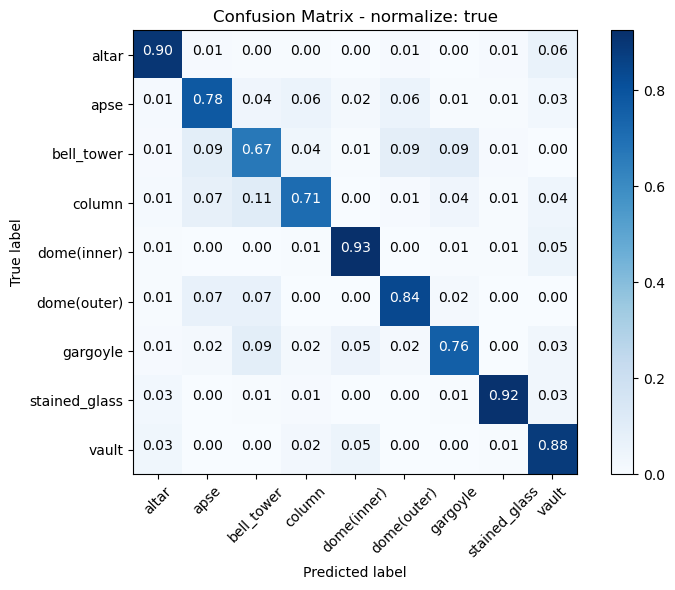

In [59]:
plot_confusion_matrix(optimized_model, test_data, 'true', 'Blues')

92/92 [==============================] - 2s 18ms/step


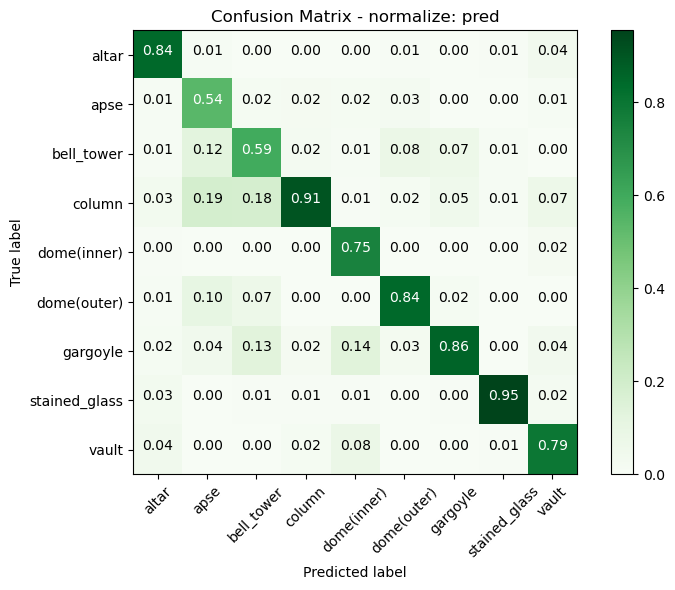

In [60]:
plot_confusion_matrix(optimized_model, test_data, 'pred', 'Greens')

92/92 [==============================] - 2s 17ms/step


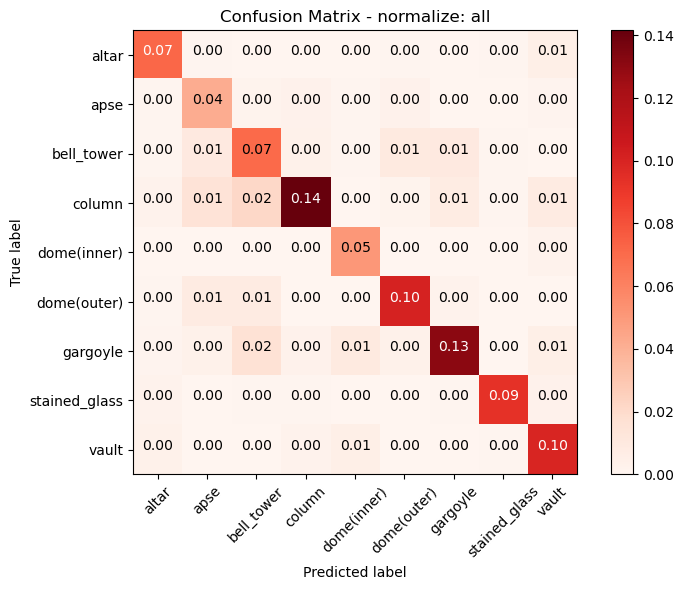

In [61]:
plot_confusion_matrix(optimized_model, test_data, 'all', 'Reds')

#### Picture predictions

In [62]:
def plot_image(predictions_array, true_label, image):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(image.astype("uint8"))
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    
    plt.xlabel(
        f"{classes[predicted_label]} {100*np.max(predictions_array):2.0f}% ({classes[true_label]})",
        color=color
    )

def plot_value_array(predictions_array, true_label):
    plt.grid(False)
    plt.xticks(range(9))
    plt.yticks([])
    value_plot = plt.bar(range(9), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    
    value_plot[predicted_label].set_color('red')
    value_plot[true_label].set_color('blue')
  
def show_predicted_pictures(predictions_arrays, labels, images, title):
    num_cols = math.floor(math.sqrt(len(images)))
    num_rows = num_cols

    plt.figure(figsize=(2*2*num_cols+2, 2*num_rows+2))
    plt.title(title)
    plt.axis('off')

    for i in range(len(images)):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(predictions_arrays[i], labels[i], images[i])
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(predictions_arrays[i], labels[i])
    plt.tight_layout()
    plt.show()
    
def get_images(data):
    images = []
    true_labels = []
    for f, l in data:
        images.extend(f.numpy())
        true_labels.extend(l.numpy())
    return np.array(images), np.array(true_labels)

raw_test_images, test_labels = get_images(raw_test_data)
test_images, _ = get_images(test_data)

test_predictions = cross_validated_model.predict(test_images)

test_scores = []
for test_prediction in test_predictions:
    test_scores.append(tf.nn.softmax(test_prediction))
test_scores = np.array(test_scores)

random_indices = np.random.choice(len(test_labels), size=9, replace=False)

errors = tf.keras.losses.sparse_categorical_crossentropy(test_labels, test_predictions).numpy()
worst_indices = np.argsort(errors)[-9:]

92/92 [==============================] - 1s 16ms/step


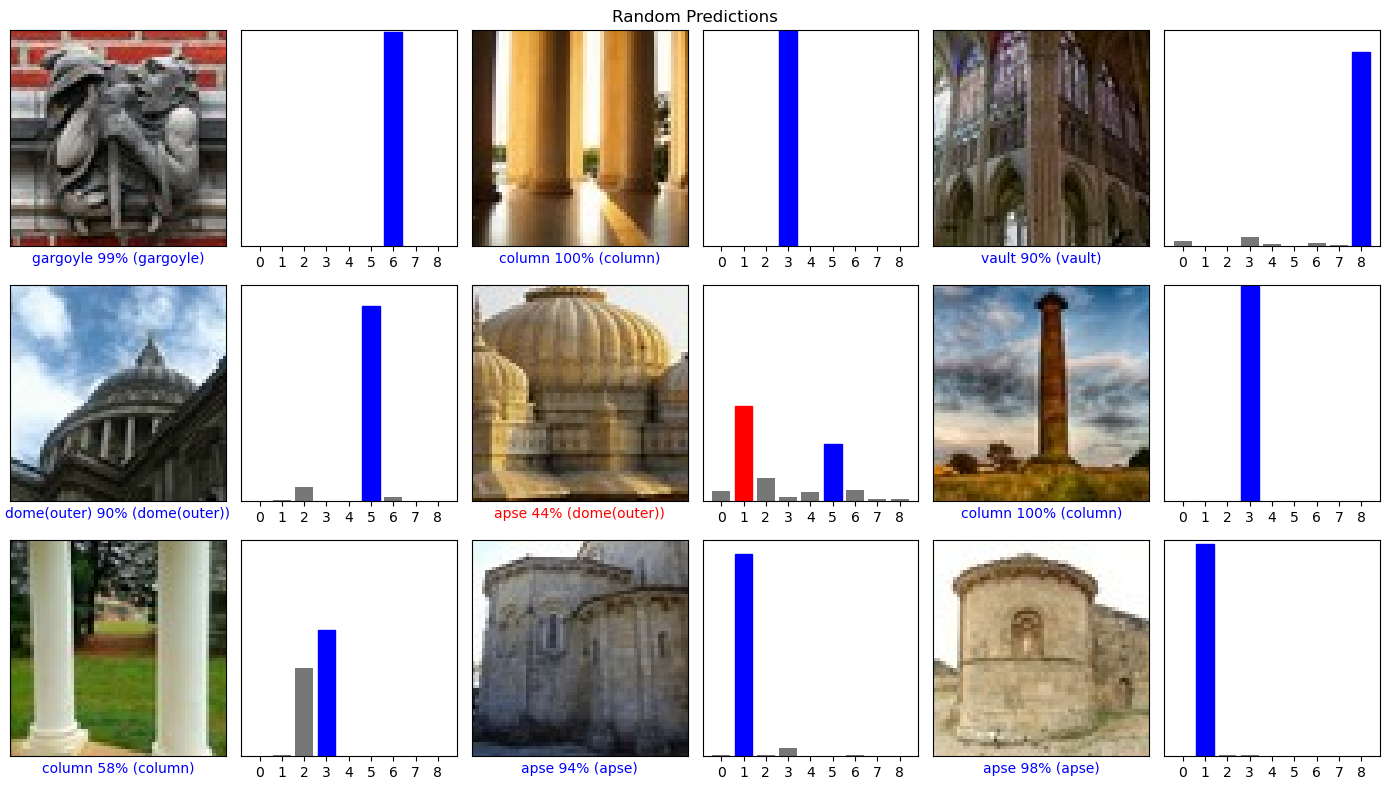

In [63]:
show_predicted_pictures(
    test_scores[random_indices],
    test_labels[random_indices],
    raw_test_images[random_indices],
    'Random Predictions'
)

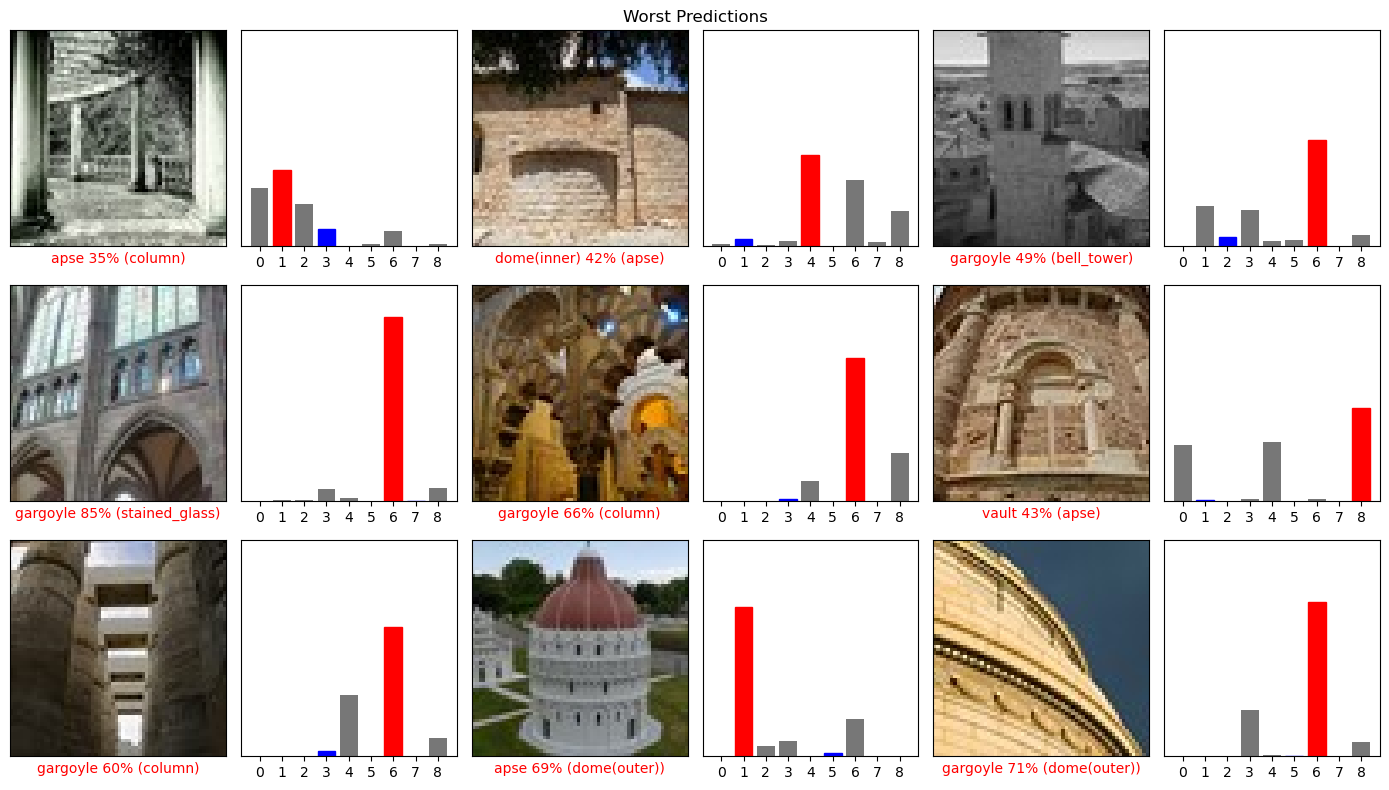

In [64]:
show_predicted_pictures(
    test_scores[worst_indices],
    test_labels[worst_indices],
    raw_test_images[worst_indices],
    'Worst Predictions'
)

### Discussion

Accuracy (0.800) and loss (0.920) for the test data is close to those of the validation (accuracy: 0.818, loss: 0.901). It is also still with one standard deviation of the cross validation (accuracy: 0.808±0.015, loss: 0.912±0.054) The confusion matrices look similar. There seems to be no problem with the data split. This also indicates that the model parameters were not fitted to the validation data.

Therefore the discussion and findings in the optimized model part still hold. A small exception is dome(outer) which was third worst in recall (0.76) and has risen two places to fifth (0.84).

## Final discussion

#### Accuracy and Loss comparison between the architectures

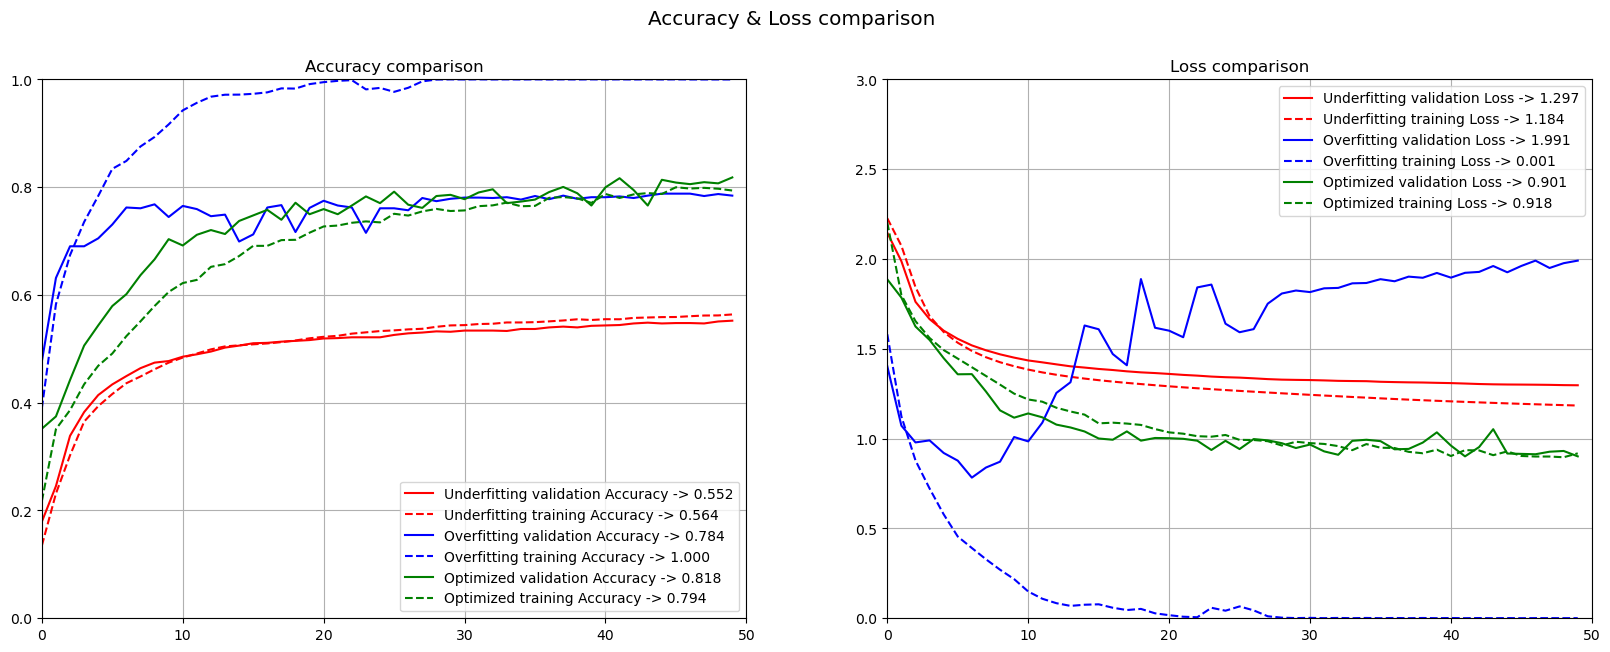

In [45]:
underfitting_train_acc = underfitting_history.history['accuracy']
underfitting_val_acc = underfitting_history.history['val_accuracy']

overfitting_train_acc = overfitting_history.history['accuracy']
overfitting_val_acc = overfitting_history.history['val_accuracy']

optimized_train_acc = optimized_history.history['accuracy']
optimized_val_acc = optimized_history.history['val_accuracy']

underfitting_train_loss = underfitting_history.history['loss']
underfitting_val_loss = underfitting_history.history['val_loss']

overfitting_train_loss = overfitting_history.history['loss']
overfitting_val_loss = overfitting_history.history['val_loss']

optimized_train_loss = optimized_history.history['loss']
optimized_val_loss = optimized_history.history['val_loss']

    
epoch_range = range(50)
    
plt.figure(figsize=(20, 7))
plt.suptitle('Accuracy & Loss comparison', fontsize='x-large')
    
plt.subplot(1, 2, 1)
underfitting_val_acc_label = f'Underfitting validation Accuracy -> {(underfitting_val_acc[-1]):.3f}'
plt.plot(epoch_range, underfitting_val_acc, label=underfitting_val_acc_label, color='red')
underfitting_train_acc_label = f'Underfitting training Accuracy -> {(underfitting_train_acc[-1]):.3f}'
plt.plot(epoch_range, underfitting_train_acc, label=underfitting_train_acc_label, color='red', linestyle='dashed')
overfitting_val_acc_label = f'Overfitting validation Accuracy -> {(overfitting_val_acc[-1]):.3f}' 
plt.plot(epoch_range, overfitting_val_acc, label=overfitting_val_acc_label, color='blue')
overfitting_train_acc_label = f'Overfitting training Accuracy -> {(overfitting_train_acc[-1]):.3f}' 
plt.plot(epoch_range, overfitting_train_acc, label=overfitting_train_acc_label, color='blue', linestyle='dashed')
optimized_val_acc_label = f'Optimized validation Accuracy -> {(optimized_val_acc[-1]):.3f}' 
plt.plot(epoch_range, optimized_val_acc, label=optimized_val_acc_label, color='green')
optimized_train_acc_label = f'Optimized training Accuracy -> {(optimized_train_acc[-1]):.3f}' 
plt.plot(epoch_range, optimized_train_acc, label=optimized_train_acc_label, color='green', linestyle='dashed')
plt.ylim(0, 1)
plt.xlim(0, 50)
plt.legend(loc='lower right')
plt.title('Accuracy comparison')
plt.grid(True)

plt.subplot(1, 2, 2)
underfitting_val_loss_label = f'Underfitting validation Loss -> {(underfitting_val_loss[-1]):.3f}'
plt.plot(epoch_range, underfitting_val_loss, label=underfitting_val_loss_label, color='red')
underfitting_train_loss_label = f'Underfitting training Loss -> {(underfitting_train_loss[-1]):.3f}'
plt.plot(epoch_range, underfitting_train_loss, label=underfitting_train_loss_label, color='red', linestyle='dashed')
overfitting_val_loss_label = f'Overfitting validation Loss -> {(overfitting_val_loss[-1]):.3f}'
plt.plot(epoch_range, overfitting_val_loss, label=overfitting_val_loss_label, color='blue')
overfitting_train_loss_label = f'Overfitting training Loss -> {(overfitting_train_loss[-1]):.3f}'
plt.plot(epoch_range, overfitting_train_loss, label=overfitting_train_loss_label, color='blue', linestyle='dashed')
optimized_val_loss_label = f'Optimized validation Loss -> {(optimized_val_loss[-1]):.3f}'
plt.plot(epoch_range, optimized_val_loss, label=optimized_val_loss_label, color='green')
optimized_train_loss_label = f'Optimized training Loss -> {(optimized_train_loss[-1]):.3f}'
plt.plot(epoch_range, optimized_train_loss, label=optimized_train_loss_label, color='green', linestyle='dashed')
plt.ylim(0, 3)
plt.xlim(0, 50)
plt.legend(loc='upper right')
plt.title('Loss comparison')
plt.grid(True)

plt.show()

### Final conclusion

The typical evolution of training history for accuracy and loss can be observed for each kind of model in the above subchapter. It is noteworthy that the optimized model's metrics vary much more between epochs. This is probably due to the high dropout rate. Still it has slightly but visibly better validation accuracy than the overfitting model.

The high precision and recall for stained glass in all models is also interesting. Finding the reason would be a whole assignment on its own. We speculate that the many small and sharply changing patches of color are an easily identifiable feature.

For the lower precision and recall classes there is less consistency. Generally the models had difficulty with recall on bell towers and with precision on bell towers and apses. They were consistently on the list of the worst. We can't speculate on the reason for this.

The low complexity of the underfitting model with only 669 parameters already had good success in validation accuracy (0.552) compared to the accuracy (0.784 and 0.818) of the high complexity models with 446'291 parameters.

The test accuracy (0.800) of the final optimized model is not bad. But looking at the sample of the most misclassified images, we think we could do a better job. Since our most complex model stagnates with or without regularization, we wonder if our architecture and its elements are the problem, or if just adding more layers, parameters, data and computing power would be better.